## 1. Imports & Environment Setup

In this section we load all Python libraries needed for data handling (`pandas`, `numpy`), visualization (`matplotlib`, `seaborn`), and model building (`tensorflow` / `keras`).

This prepares our Python environment for the entire notebook.

In [18]:
# Imports and setup
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    matthews_corrcoef
)

## 2. Dataset Loading & Initial Overview

Here we:

1. Read the **CSV** file into a `DataFrame`.
2. Print its **shape** (rows × columns) to understand the data volume.
3. Display the first few rows (`.head()`) to inspect column names, data types, and spot any glaring issues (e.g., missing values).

This quick check guides our next steps in cleaning and exploration.


In [19]:
# Load the dataset and display its shape and head data
path = '../Data/Fraud_Cleaned.csv'
df = pd.read_csv(path)
print(f"Loaded data with shape: {df.shape}")
df.head()

Loaded data with shape: (498050, 10)


,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModification,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,4,467,88.48,4,8,4,0.014989,0.189465,0.571429,0
1,3,1004,58.99,7,6,1,0.026892,0.058755,0.259259,0
2,1,162,14.00,4,5,4,0.006173,0.086420,4.000000,0
3,5,532,84.79,9,3,4,0.026316,0.159380,0.642857,0
4,5,890,42.16,4,0,0,0.021348,0.047371,0.210526,0


## 3. Target Distribution Analysis

We examine the balance of our classes by calculating and displaying the count of **fraud** vs **non-fraud** transactions.


In [20]:
# Print the Dataset fraud distribution
print("Fraud proportion:")
print(df['fraud'].value_counts(normalize=True))

Fraud proportion:
fraud
0    0.952366
1    0.047634
Name: proportion, dtype: float64


## 4. Train / Validation / Test Split

We partition the data to:

- **Train set (70%)**: used to fit the model.
- **Validation set (15%)**: used for hyperparameter tuning and early stopping.
- **Test set (15%)**: reserved for final evaluation.

Ensuring no data leakage between these sets guarantees a fair assessment of model generalization.


In [21]:
# Splitting of dataset and scaling for NN. Stratified splits ensure even distribution of fraud cases and a random state ensures reproducibility.
X = df.drop('fraud', axis=1)
y = df['fraud']

X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (348635, 9), Val: (74707, 9), Test: (74708, 9)


## 5. Defining Cost-Sensitive Class Weights

Because false positive (accused customers that did not engage in fraudulent transactions) are costlier than false positives:

- We assign a higher weight to the minority class in the loss function.
- Here, we set **FP cost = 5 × FN cost** to bias the model towards catching less fraud in order to prevent checking non-fraudulent customers.

This guides the training algorithm to penalize misclassifying fraud more heavily.


In [22]:
# Cost-sensitive class weights (FP cost = 5× FN cost)
class_weights = {0: 5, 1: 1}
print(f"Class weights: {class_weights}")

Class weights: {0: 5, 1: 1}


## 6. Neural Network Architecture

In this block we:

- Define a sequential neural network with layers such as Dense, Dropout, and appropriate activation functions.
- Choose an optimizer (e.g., `Adam`), loss function (`binary_crossentropy`), and metrics (`AUC`, `Precision`, `Recall`).
- Summarize the model to review layer shapes and parameter counts.

This blueprint determines the capacity and regularization of our fraud detector.


In [23]:
# Building the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid'),
])

model.compile(
    optimizer=Adam(1e-3),
    loss='binary_crossentropy',
    metrics=[
        AUC(name='roc_auc', curve='ROC'),
        AUC(name='pr_auc',  curve='PR')
    ]
)
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 64)                640       
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_25 (Dense)            (None, 32)                2080      
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                                 
 dense_26 (Dense)            (None, 16)                528       
                                                                 
 dense_27 (Dense)            (None, 1)                 17        
                                                                 
Total params: 3,265
Trainable params: 3,265
Non-traina

## 7. Model Training & Early Stopping

We train the network using:

- The **training set** and monitor performance on the **validation set**.
- An **EarlyStopping** callback that halts training once the validation AUC stops improving for 10 epochs in a row (to prevent overfitting).
- A defined number of **epochs** and **batch size**.

This yields the best model checkpoint before validation performance degrades.


In [24]:
# Train the model with early stopping
es = EarlyStopping(
    monitor='val_pr_auc',
    mode='max',
    patience=10,
    restore_best_weights=True
)

# 3) Then, in your training cell, pass that callback as usual:
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[es]
)

Epoch 1/100
5448/5448 [==============================] - 14s 2ms/step - loss: 0.1649 - roc_auc: 0.9573 - pr_auc: 0.6070 - val_loss: 0.0604 - val_roc_auc: 0.9925 - val_pr_auc: 0.9368
Epoch 2/100
5448/5448 [==============================] - 15s 3ms/step - loss: 0.0714 - roc_auc: 0.9914 - pr_auc: 0.9174 - val_loss: 0.0420 - val_roc_auc: 0.9964 - val_pr_auc: 0.9504
Epoch 3/100
5448/5448 [==============================] - 11s 2ms/step - loss: 0.0671 - roc_auc: 0.9922 - pr_auc: 0.9275 - val_loss: 0.0362 - val_roc_auc: 0.9976 - val_pr_auc: 0.9631
Epoch 4/100
5448/5448 [==============================] - 11s 2ms/step - loss: 0.0656 - roc_auc: 0.9926 - pr_auc: 0.9304 - val_loss: 0.0410 - val_roc_auc: 0.9971 - val_pr_auc: 0.9655
Epoch 5/100
5448/5448 [==============================] - 12s 2ms/step - loss: 0.0629 - roc_auc: 0.9929 - pr_auc: 0.9351 - val_loss: 0.0308 - val_roc_auc: 0.9978 - val_pr_auc: 0.9633
Epoch 6/100
5448/5448 [==============================] - 12s 2ms/step - loss: 0.0624 - roc

## 8. Training History: AUC Over Epochs

Visualize:

- **Training ROC-AUC** vs **Validation ROC-AUC** per epoch.  
- **Training PR-AUC** vs **Validation PR-AUC** per epoch.  
- Identify if/when the model begins to overfit (divergence in ROC-AUC) or loses precision–recall performance.  
- Decide if further regularization or more data is needed.

This diagnostic plot guides future tuning.



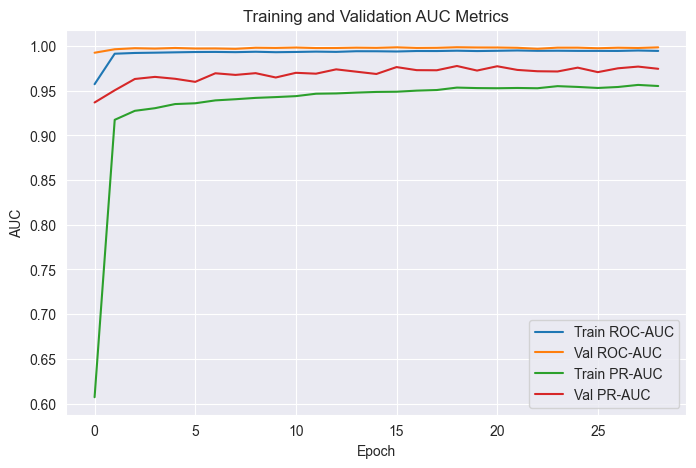

In [25]:
# Plot ROC-AUC and PR-AUC history
plt.figure(figsize=(8, 5))
plt.plot(history.history['roc_auc'], label='Train ROC-AUC')
plt.plot(history.history['val_roc_auc'], label='Val ROC-AUC')
plt.plot(history.history['pr_auc'], label='Train PR-AUC')
plt.plot(history.history['val_pr_auc'], label='Val PR-AUC')
plt.title('Training and Validation AUC Metrics')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()


## 9. Precision–Recall Curve (Validation)

On the validation set:

- Compute precision and recall across thresholds.
- Plot the **Precision–Recall** curve to understand trade-offs.
- Compute the **area under the PR curve** as another performance metric for imbalanced data.

This helps select an operating point that balances catching fraud vs. false alarms.


2335/2335 [==============================] - 3s 1ms/step


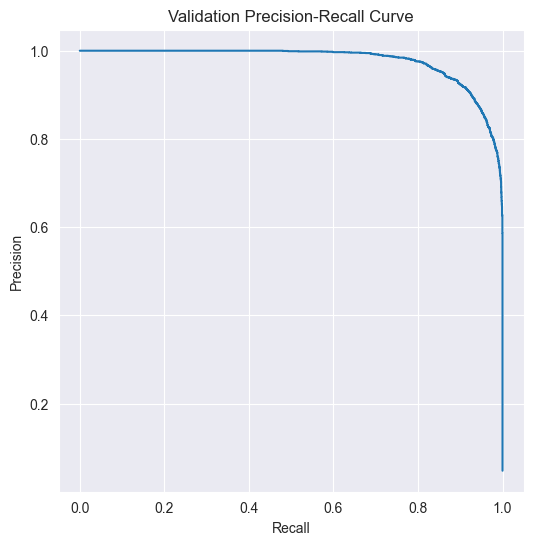

In [26]:
# Precision-Recall curve on validation set
y_val_prob = model.predict(X_val_scaled).ravel()
precision_vals, recall_vals, pr_thresholds = precision_recall_curve(y_val, y_val_prob)

plt.figure(figsize=(6, 6))
plt.plot(recall_vals, precision_vals)
plt.title('Validation Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

## 10. Determining Cost-Optimal Threshold

We:

1. Evaluate model predictions at many thresholds.
2. Compute the **expected cost** at each threshold using our cost matrix.
3. Select the threshold minimizing total cost on the validation set.

This threshold will be used for final binary classification.


Best threshold = 0.36, Cost = 1043


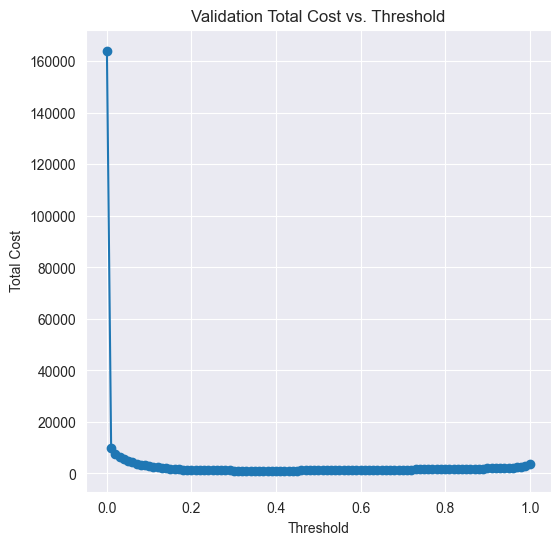

In [27]:
# Find cost-optimal threshold on validation set
def calculate_cost(thresh, y_true, y_prob, fp_cost=5, fn_cost=1):
    y_pred = (y_prob > thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp * fp_cost + fn * fn_cost

thresholds = np.linspace(0, 1, 101)
costs = [calculate_cost(t, y_val, y_val_prob) for t in thresholds]

best_idx = np.argmin(costs)
best_thresh = thresholds[best_idx]
best_cost = costs[best_idx]
print(f"Best threshold = {best_thresh:.2f}, Cost = {best_cost}")

plt.figure(figsize=(6, 6))
plt.plot(thresholds, costs, marker='o')
plt.title('Validation Total Cost vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Total Cost')
plt.show()

## 11. Final Evaluation on Test Set

Apply the chosen threshold to the **test set** predictions:

- Generate the confusion matrix.
- Compute final metrics: **True Positive Rate**, **False Positive Rate**, **Precision**, **Recall**, and **Total Cost**.
- Compare against validation results to confirm generalization.

This is the definitive performance report.


Using threshold = 0.36 for test evaluation
2335/2335 [==============================] - 3s 1ms/step


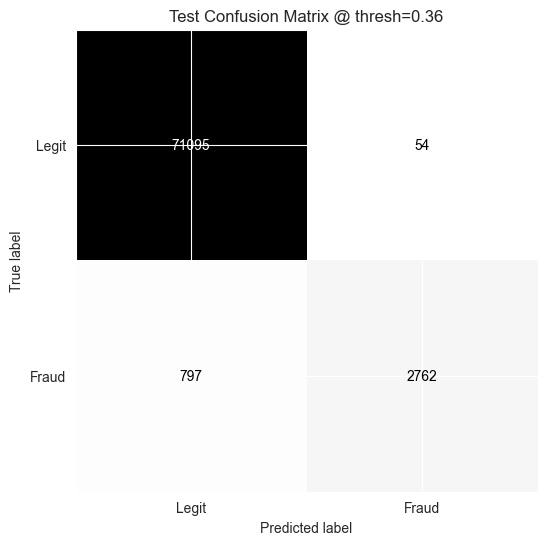

Test set size: 74708
Fraud cases (positives): 3559
Non-fraud cases (negatives): 71149


In [28]:
# Evaluate on test set using cost-optimal threshold
print(f"Using threshold = {best_thresh:.2f} for test evaluation")

y_test_prob = model.predict(X_test_scaled).ravel()
y_test_pred = (y_test_prob > best_thresh).astype(int)

# Confusion matrix (grayscale)
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['Legit', 'Fraud'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='gray_r', colorbar=False)
ax.set_title(f'Test Confusion Matrix @ thresh={best_thresh:.2f}')
plt.show()

# Assuming y_test is your array or Series of true labels:

# Total size of the test set
print(f"Test set size: {len(y_test)}")

# Number of positive cases (fraud = 1)
num_positives = y_test.sum()
print(f"Fraud cases (positives): {num_positives}")

# Number of negative cases (no fraud = 0)
num_negatives = len(y_test) - num_positives
print(f"Non-fraud cases (negatives): {num_negatives}")

## 12. Summary Metrics Table

Organize all key metrics into a single table for clear comparison.
This tabular view is ideal for communicating results to stakeholders.


In [29]:
# Metrics table on test set
metrics = {
    'Accuracy': accuracy_score(y_test, y_test_pred),
    'Precision': precision_score(y_test, y_test_pred),
    'Recall': recall_score(y_test, y_test_pred),
    'F1 Score': f1_score(y_test, y_test_pred),
    'ROC AUC': roc_auc_score(y_test, y_test_prob),
    'MCC': matthews_corrcoef(y_test, y_test_pred)
}

pd.DataFrame([metrics])

,Accuracy,Precision,Recall,F1 Score,ROC AUC,MCC
0,0.988609,0.980824,0.776061,0.86651,0.998724,0.867087


## 13. Model Export

Finally, we:

- Serialize the trained model to disk (e.g., `model.save('fraud_nn.h5')`).
This makes the model ready for deployment in the retailer’s fraud-detection system.


In [30]:
# Export the trained model
import os

# save as HDF5
export_path = '../Models/NeuralNetwork_Model.h5'
model.save(export_path)
print(f"Model exported to {export_path}")

Model exported to ../Models/NeuralNetwork_Model.h5
